In [11]:
import os
import shutil
import random

# main_directory = "/Users/rich/Desktop/AI-music/Data"

# #move files from subfolders to main folder
# for folder_name in os.listdir(main_directory):
#     folder_path = os.path.join(main_directory, folder_name)
#     if os.path.isdir(folder_path):
#         for file_name in os.listdir(folder_path):
#             file_path = os.path.join(folder_path, file_name) 
#             if file_name != ".DS_Store":
#                 destination_path = os.path.join(main_directory, file_name)
#                 shutil.move(file_path, destination_path)
# #del subfolders
# for folder_name in os.listdir(main_directory):
#     folder_path = os.path.join(main_directory, folder_name)
#     if os.path.isdir(folder_path):
#         shutil.rmtree(folder_path)
# #rename files
# count = 1
# for file_name in os.listdir(main_directory):
#     file_path = os.path.join(main_directory, file_name)
#     if os.path.isfile(file_path):
#         new_file_name = str(count) + os.path.splitext(file_name)[1]
#         new_file_path = os.path.join(main_directory, new_file_name)
#         os.rename(file_path, new_file_path)
#         count += 1

In [12]:
# import shutil
# import os

# # Specify the source directory where the files are currently located
# source_directory = '/Users/rich/Desktop/AI-music/Data'

# # Specify the destination directory where you want to move the files
# destination_directory = '/Users/rich/Desktop/AI-music/Original Data'

# # Get a list of all the files in the source directory
# file_list = os.listdir(source_directory)

# # Iterate over each file and move it to the destination directory
# for file_name in file_list:
#     # Construct the full path of the source file
#     source_file = os.path.join(source_directory, file_name)
    
#     # Construct the full path of the destination file
#     destination_file = os.path.join(destination_directory, file_name)
    
#     # Move the file to the destination directory
#     shutil.move(source_file, destination_file)


In [13]:
import pretty_midi
import numpy as np
import glob
import mido

# # MIDI轉換為10秒長度的MIDI
# def convert_to_10_seconds(input_file, output_file):
#     # 打開 MIDI 文件
#     mid = mido.MidiFile(input_file)

#     # 計算所有消息的時間總和
#     total_ticks = sum([msg.time for msg in mid])

#     # 計算每秒的 tick 數    
#     ticks_per_second = 480

#     # 10 秒的 tick 数
#     target_ticks = ticks_per_second * 10

#     # 計算縮放因子
#     scale_factor = target_ticks / total_ticks

#     # 創建一個新的 MIDI 文件
#     new_mid = mido.MidiFile()


#     for track in mid.tracks:
#         # 創建一個新的軌道
#         new_track = mido.MidiTrack()

#         for msg in track:
#             # 調整消息的時間
#             new_time = int(msg.time * scale_factor)
#             new_msg = msg.copy(time=new_time)

#             # 將消息添加到新軌道中
#             new_track.append(new_msg)

#         # 添加到新的 MIDI 文件中
#         new_mid.tracks.append(new_track)

#     # 保存新 MIDI 文件
#     new_mid.save(output_file)


# original_data_path = '/Users/rich/Desktop/AI-music/Datasets/Original Data/'
# converted_data_folder = '/Users/rich/Desktop/AI-music/Datasets/Convert Data/'
# if not os.path.exists(converted_data_folder):
#     os.makedirs(converted_data_folder)


# midi_file_paths = glob.glob(original_data_path + '*.mid')

# for file_path in midi_file_paths:
#     #這裡用try except是因為有些midi檔案有問題，會導致程式出錯
#     try:
#         input_file = file_path
#         output_file = os.path.join(converted_data_folder, 'converted_' + os.path.basename(file_path))
#         convert_to_10_seconds(input_file, output_file)

#     except:
#         pass

In [14]:
# 隨機選取500個midi檔案
# midi_file_paths = glob.glob('/Users/rich/Desktop/AI-music/Datasets/Convert Data/*.mid')
# selected_file_paths = random.sample(midi_file_paths, 500)
# # 儲存所有音符和力度
# all_notes = []
# all_velocities = []

# for file_path in selected_file_paths:
#     try:
#         midi_data = pretty_midi.PrettyMIDI(file_path)
#         notes = []
#         velocities = []

#         # 每個樂器有多個音符
#         # 每個音符有兩個屬性：音高和力度
#         for instrument in midi_data.instruments:
#             for note in instrument.notes:
#                 notes.append(note.pitch)
#                 velocities.append(note.velocity)

#         all_notes.extend(notes)
#         all_velocities.extend(velocities)

#     except:
#         pass

# notes_array = np.array(all_notes)
# velocities_array = np.array(all_velocities)

# np.save('notes_array.npy', notes_array)
# np.save('velocities_array.npy', velocities_array)

In [15]:
notes_array = np.load('notes_array.npy')
velocities_array = np.load('velocities_array.npy')

#normalize
notes_normalized = notes_array.reshape(-1, 1) / float(notes_array.max())
velocities_normalized = velocities_array.reshape(-1, 1) / float(velocities_array.max())

# combine notes and velocities
combined_data = np.concatenate((notes_normalized, velocities_normalized), axis=1)

sequence_length = 100
inputs = []
targets = []

for i in range(len(combined_data) - sequence_length):
    inputs.append(combined_data[i:i+sequence_length])
    targets.append(combined_data[i+sequence_length])


#split data
split_index = int(0.8 * len(inputs)) 

train_inputs = np.array(inputs[:split_index])
train_targets = np.array(targets[:split_index])

test_inputs = np.array(inputs[split_index:])
test_targets = np.array(targets[split_index:])

In [18]:
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(LSTM(256, input_shape=(train_inputs.shape[1], train_inputs.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(128, return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(64))
model.add(BatchNormalization())
model.add(Dense(32))
model.add(Dense(2))
model.compile(loss='mse', optimizer='adam')

history = model.fit(train_inputs, train_targets, epochs=20, batch_size=128, validation_data=(test_inputs, test_targets))
model.save('model')

Epoch 1/20
16247/16247 [==============================] - 6728s 414ms/step - loss: 0.0102 - val_loss: 0.0470
Epoch 2/20
16247/16247 [==============================] - 991s 61ms/step - loss: 0.0086 - val_loss: 0.0139
Epoch 3/20
16247/16247 [==============================] - 1009s 62ms/step - loss: 0.0076 - val_loss: 0.0109
Epoch 4/20
16247/16247 [==============================] - 996s 61ms/step - loss: 0.0072 - val_loss: 0.0102
Epoch 5/20
16247/16247 [==============================] - 996s 61ms/step - loss: 0.0072 - val_loss: 0.0100
Epoch 6/20
16247/16247 [==============================] - 1010s 62ms/step - loss: 0.0070 - val_loss: 0.0085
Epoch 7/20
16247/16247 [==============================] - 1000s 62ms/step - loss: 0.0065 - val_loss: 0.0090
Epoch 8/20
16247/16247 [==============================] - 999s 61ms/step - loss: 0.0063 - val_loss: 0.0084
Epoch 9/20
16247/16247 [==============================] - 1008s 62ms/step - loss: 0.0062 - val_loss: 0.0076
Epoch 10/20
16247/16247 [======

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


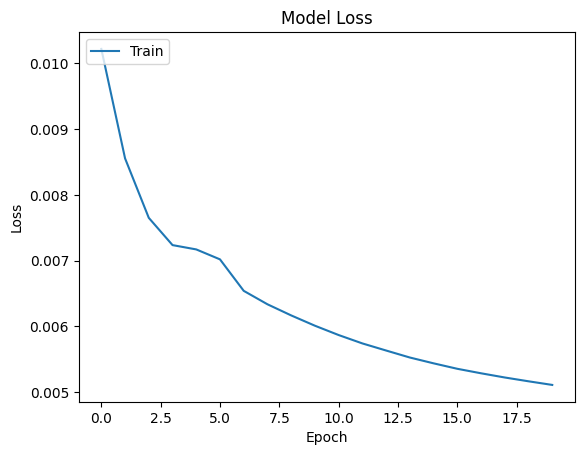

In [19]:
#plot loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [20]:
#generate music
generated_sequence = []

start_index = np.random.randint(0, len(test_inputs)-1)
input_sequence = test_inputs[start_index]
sequence_length = 10

for _ in range(sequence_length):
    predicted = model.predict(np.expand_dims(input_sequence, axis=0))
    generated_sequence.append(predicted[0])
    input_sequence = np.concatenate((input_sequence[1:], np.expand_dims(predicted[0], axis=0)))

generated_sequence = notes_array.max() * generated_sequence


1/1 [==============================] - 0s 29ms/step


In [22]:
#convert to midi
from music21 import stream, note, tempo

music_stream = stream.Stream()
#設置一個速度
default_tempo = tempo.MetronomeMark(number=100)

#提取音高還有持續時間
for sequence in generated_sequence:
    pitch = int(sequence[0])  
    duration = float(sequence[1])  

    n = note.Note()
    n.pitch.midi = pitch
    n.duration.quarterLength = duration

    music_stream.append(n)

music_stream.insert(0, default_tempo)

output_folder = '/Users/rich/Desktop/AI-music/Generated_music'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

midi_filename = "generated_music05.mid"
output_path = os.path.join(output_folder, midi_filename)

music_stream.write("midi", fp=output_path)

'/Users/rich/Desktop/AI-music/Generated_music/generated_music05.mid'